
## 3.6 softmax回归

### 3.6.1 spiral数据集

下面的代码生成一个二维平面上的3分类数据集：

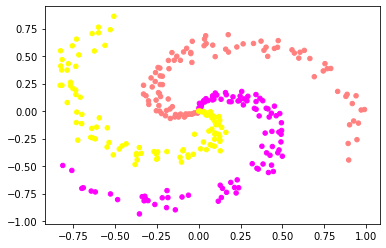

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(100)

def gen_spiral_dataset(N=100,D=2,K=3):
    N = 100 # number of points per class
    D = 2 # dimensionality
    K = 3 # number of classes
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0,1,N) # radius
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2  # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    return X,y

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

X_spiral,y_spiral = gen_spiral_dataset()
# lets visualize the data:
plt.scatter(X_spiral[:, 0], X_spiral[:, 1], c=y_spiral, s=20, cmap=plt.cm.spring) #s=40, cmap=plt.cm.Spectral)
plt.show()

### 3.6.2 softmax函数

In [2]:
import numpy as np

def softmax(x):
    e_x = np.exp(x)
    return e_x / e_x.sum()

In [3]:
z = [3.0, 1.0, 0.2]
softmax(z)

array([0.8360188 , 0.11314284, 0.05083836])

In [4]:
z = [100,1000]
softmax(z)

/var/folders/rj/kh58t7hj5s99k8krgn4brl1c0000gn/T/ipykernel_34177/1226439361.py:4: RuntimeWarning: overflow encountered in exp
  e_x = np.exp(x)
/var/folders/rj/kh58t7hj5s99k8krgn4brl1c0000gn/T/ipykernel_34177/1226439361.py:5: RuntimeWarning: invalid value encountered in divide
  return e_x / e_x.sum()


array([ 0., nan])

因此，可以先求出所有${z_i}$的最大值a，然后用${z_i-a}$去计算softmax()函数值。

In [5]:
def softmax(x):   
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

print(softmax(z))
z = [500,1000]
softmax(z)

[0. 1.]


array([7.12457641e-218, 1.00000000e+000])

In [6]:
z = np.array([[1, 2, 3],[6, 2, 4]])
softmax(z)

array([[0.00548473, 0.01490905, 0.04052699],
       [0.8140064 , 0.01490905, 0.11016379]])

对多个样本，应计算它们各自的softmax()函数值，即对每个样本单独计算其softmax值向量。正确代码应该是:

In [7]:
def softmax(x):   
    a= np.max(x,axis=-1,keepdims=True)  
    e_x = np.exp(x - a)
    return e_x /np.sum(e_x,axis=-1,keepdims=True)

softmax(z)

array([[0.09003057, 0.24472847, 0.66524096],
       [0.86681333, 0.01587624, 0.11731043]])

In [8]:
def softmax(x):
    e_x=np.exp(x-np.max(x,axis=-1,keepdims=True))
    return e_x /np.sum(e_x,axis=-1,keepdims=True)

softmax(z)

array([[0.09003057, 0.24472847, 0.66524096],
       [0.86681333, 0.01587624, 0.11731043]])

一般的，假设$\pmb z = (z_1,z_2,\cdots,z_k,\cdots,z_C)$，用$f(\pmb z)$表示$softmax(\pmb z)$函数，则有：

$$f_i = \frac{e^{z_i}}{\sum_{k=1}^C e^{z_k}}$$

其中，$\sum_{i=1}^C f_i = 1$。

$\pmb f$关于$\pmb z$的梯度可如下计算：

In [10]:
def softmax_gradient(z):    
    f = softmax(z)
    grad = -np.outer(f, f) + np.diag(f.flatten())
    return grad

用df表示某个其他变量$L$关于$f$的梯度，则$L$关于$z$的梯度的python计算代码如下：

In [11]:
def softmax_backward(z,df):    
    f = softmax(z)
    grad = -np.outer(f, f) + np.diag(f.flatten())
    
    return df@grad

### 3.6.3 softmax回归

$$f(\pmb x) =  softmax (\pmb x\pmb W_{,1},\pmb x\pmb W_{,2},\pmb x\pmb W_{,3}) =  softmax(\pmb x \pmb W) $$

$$L(\pmb W) = -\frac{1}{m} \sum_{i=1}^{m} log({f^{(i)}_{y^{(i)}}}) $$

$$L(\pmb W) = -\frac{1}{m} \sum_{i=1}^{m} log({f^{(i)}_{y^{(i)}}})  = -\frac{1}{m} sum (log \pmb F_{\pmb y}) $$

计算交叉熵的python代码如下：

In [9]:
def cross_entropy(F,y):
    m = len(F) #y.shape[0]
    log_Fy = -np.log(F[range(m),y])    
    return np.sum(log_Fy) / m  

用这个函数计算例子中的交叉熵：

In [10]:
F = np.array([[0.2,0.5,0.3],[0.2,0.6,0.2]])  #每行对应一个样本
Y = np.array([2,1])

print(-1/2*(np.log(0.3)+np.log(0.6)))
print(cross_entropy(F,Y))

0.8573992140459634
0.8573992140459634


对于一个样本，如果其对应的$y^{(i)}$的第j个分量$y^{(i)}_j = 1$，即该样本属于第j类，则该样本的交叉熵损失可写成：

$$-\log(f^{(i)}_j) =-y^{(i)}_j \log(f^{(i)}_j) = - \sum_{j=1}^C y^{(i)}_j \log(f^{(i)}_j) = -y^{(i)} \cdot log(f^{(i)}) $$

针对one-hot形式表示的目标值，可以将所有样本的交叉熵损失写成如下形式：

$$\begin{aligned}L(\pmb W) &= -\frac{1}{m} \sum_{i=1}^m y^{(i)}\cdot log(f^{(i)})= -\frac{1}{m} np.sum(Y \odot log(F) )\end{aligned}$$

对应的python计算代码如下：

In [11]:
def cross_entropy_one_hot(F,Y):
    m = len(F) 
    return -np.sum(Y*np.log(F))/m  # -(1./m) *np.sum(np.multiply(y, np.log(f)))

F = np.array([[0.2,0.5,0.3],[0.2,0.6,0.2]])  #每行对应一个样本
Y = np.array([[0,0,1],[0,1,0]])

print(cross_entropy_one_hot(F,Y))

0.8573992140459634


### 3.6.5 通过加权和计算交叉熵损失

In [12]:
def softmax(Z):
    A = np.exp(Z-np.max(Z,axis=1,keepdims=True))
    return A/np.sum(A,axis=1,keepdims=True)

def softmax_cross_entropy(Z,y):
    m = len(Z)
    F = softmax(Z)
    log_Fy = -np.log(F[range(m),y])
    return  np.sum(log_Fy) / m

In [13]:
Z = np.array([[2,25,13],[54,3,11]])  #每行对应一个样本
y = np.array([2,1])
softmax_cross_entropy(Z,y)

31.500003072148047

如果目标标签是one-hot向量形式，则下面代码从加权和计算交叉熵损失：

In [14]:
def softmax_cross_entropy_one_hot(Z, y):    
    F = softmax(Z)
    loss =  -np.sum(y*np.log(F),axis=1)
    return np.mean(loss)  

In [15]:
Z = np.array([[2,25,13],[54,3,11]])  #每行对应一个样本
y = np.array([[0, 0, 1],[0, 1, 0]])
softmax_cross_entropy_one_hot(Z,y)

31.500003072148047

### 3.6.6 softmax回归的梯度计算

$$\nabla_Z{\mathcal L} = \pmb F -\pmb I_i$$

或者

$$\nabla_Z{\mathcal L} = \pmb F -\pmb Y$$

In [16]:
def grad_softmax_crossentropy(Z,y):
    F = softmax(Z)
    I_i = np.zeros_like(Z)
    I_i[np.arange(len(Z)),y] = 1   
    return (F - I_i) / Z.shape[0]

In [17]:
def grad_softmax_cross_entropy(Z,y):
    m = len(Z)
    F = softmax(Z) 
    F[range(m),y] -= 1
    return F/m  

In [18]:
Z = np.array([[2,25,13],[54,3,11]])  #每行对应一个样本
y = np.array([2,1])
grad_softmax_cross_entropy(Z,y)
#grad_softmax_crossentropy(Z,y)

array([[ 5.13090829e-11,  4.99996928e-01, -4.99996928e-01],
       [ 5.00000000e-01, -5.00000000e-01,  1.05756552e-19]])

为了确保分析梯度计算没有错误，可以用1.4)节的通用数值梯度函数计算交叉熵关于Z的数值梯度和上述的分析梯度进行比较：

In [19]:
def loss_f():
    return softmax_cross_entropy(Z,y)

import util
Z = Z.astype(float)        #注意：必须将整数数组转化成float类型
print("num_grad",util.numerical_gradient(loss_f,[Z]))

ModuleNotFoundError: No module named 'util'

如果样本目标是使用one-hot向量表示的，则计算交叉熵关于Z的梯度代码如下：

In [20]:
def grad_softmax_crossentropy_one_hot(Z, y):   #y是用one-hot向量表示的
    F = softmax(Z) 
    return (F - y)/Z.shape[0]

Z = np.array([[2,25,13],[54,3,11]])  #每行对应一个样本
y = np.array([[0, 0, 1],[0, 1, 0]])
grad_softmax_crossentropy_one_hot(Z,y)

array([[ 5.13090829e-11,  4.99996928e-01, -4.99996928e-01],
       [ 5.00000000e-01, -5.00000000e-01,  1.05756552e-19]])

则损失函数关于权重$\pmb W$的梯度的向量形式是：

$$ \frac {\partial{\mathcal L}} {\partial{\pmb W } } = {\pmb X}^T {(\pmb F-\pmb Y)} \tag{3-61}$$

同样，可以给softmax回归的交叉熵损失添加正则项，如果用整数表示目标值，即损失函数变为：

$$L(\pmb W) = -\frac{1}{m} \sum_{i=1}^{m} log({f^{(i)}_{y^{(i)}}}) +\lambda \|\pmb W\|^2  \tag{3-62}$$

如果用one-hot向量表示目标值，则即损失函数变为：

$$L(\pmb W) =-\frac{1}{m} \sum_{i=1}^m y^{(i)}\dot log(f^{(i)}) +\lambda \|W\|^2  \tag{3-63} $$


则损失函数关于权重$\pmb W$的梯度是：

$$ \frac {\partial{\mathcal L}} {\partial{\pmb W } } = {\pmb X}^T {(\pmb F-\pmb Y)} +2 \lambda \pmb W  \tag{3-64}$$

根据梯度的计算公式，可以很容易写出损失函数关于$\pmb W$的梯度的计算代码。下列代码中，假设X表示多个样本的数据特征矩阵，y表示目标值向量，reg是正则化参数$\lambda$，loss_softmax()和gradient_softmax()分别计算损失函数的损失和关于$\pmb W$的梯度：

In [21]:
def gradient_softmax(W,X,y,reg):
    m = len(X)
    Z=  np.dot(X,W)
    
    I_i = np.zeros_like(Z)
    I_i[np.arange(len(Z)),y] = 1
    F = softmax(Z)
    #F = np.exp(Z) / np.exp(Z).sum(axis=-1,keepdims=True)
    grad =  (1 / m) * np.dot(X.T,F - I_i)      # Z.shape[0]
    grad = grad +2*reg*W
    return grad

def loss_softmax(W,X,y,reg):
    m = len(X)
    Z=  np.dot(X,W)   
    loss =  softmax_cross_entropy(Z,y)+reg*np.sum(W*W)
    return loss  


def loss_softmax_(W,X,y,reg):
    m = len(X)
    Z=  np.dot(X,W) 
    Z_i_y_i = Z[np.arange(len(Z)),y]
    negtive_log_prob = - Z_i_y_i + np.log(np.sum(np.exp(Z),axis=-1))
    loss =  np.mean(negtive_log_prob)+reg*np.sum(W*W)
    return loss  

用下列数据测试一下这个函数：

In [22]:
X = np.array([[2,3],[4,5]])  #每行对应一个样本,每个样本是2个特征
y = np.array([2,1])             #类别数是3
W = np.array([[0.1,0.2,0.3],[0.4,0.2,0.8]])  #  2X3矩阵

reg = 0.2;

print(gradient_softmax(W,X,y,reg))
print(loss_softmax(W,X,y,reg))
print(loss_softmax_(W,X,y,reg))

[[ 0.30213245 -1.75779321  1.69566076]
 [ 0.5254108  -2.19194012  2.22652932]]
2.0863049636282662
2.0863049636282662


如果用one-hot向量表示每个样本的目标值，y表示多个样本的目标值构成的矩阵，则下面的loss_softmax_onthot()和gradient_softmax_onthot()分别计算损失函数的损失和关于$\pmb W$的梯度：

In [23]:
def gradient_softmax_onehot(W,X,y,reg):
    m = len(X)   #样本数目
    nC = W.shape[1]   #类别数目
    #y_one_hot = np.eye(nC)[y[:,0]]
    y_one_hot = y
    
    Z = np.dot(X,W)      # Z是加权和
    F = softmax(Z)       # F是概率矩阵
    grad = (1 / m) * np.dot(X.T,(F - y_one_hot)) + 2*reg*W 
    return grad

def loss_softmax_onehot(W,X,y,reg):
    m = len(X)  #First we get the number of training examples
    nC = W.shape[1]
    #y_one_hot = np.eye(nC)[y[:,0]]
    y_one_hot = y
    
   # y_mat = oneHotIt(y)  #将整数类编码转换为one-hot向量形式
    Z = np.dot(X,W)       # Z是加权和
    F = softmax(Z)        # F是概率矩阵
    loss = (-1 / m) * np.sum(y_one_hot * np.log(F)) + (reg)*np.sum(W*W) 
    return loss

In [24]:
X = np.array([[2,3],[4,5]])  #每行对应一个样本,每个样本是2个特征
y = np.array([[0,0,1],[0,1,0]])             #类别数是3
W = np.array([[0.1,0.2,0.3],[0.4,0.2,0.8]])  #  2X3矩阵

reg = 0.2;
print(gradient_softmax_onehot(W,X,y,reg))
print(loss_softmax_onehot(W,X,y,reg))

[[ 0.30213245 -1.75779321  1.69566076]
 [ 0.5254108  -2.19194012  2.22652932]]
2.0863049636282662


### 3.6.7 softmax回归的梯度下降法的实现

在此基础上的梯度下降算法代码如下：

In [25]:
def gradient_descent_softmax(w,X, y, reg=0., alpha=0.01, iterations=100,gamma = 0.8,epsilon=1e-8):
    X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype),X))  #添加一列特征1  
    v= np.zeros_like(w)
    #losses = []
    w_history=[] 
    for i in range(0,iterations):
        gradient = gradient_softmax(w,X,y,reg)
        if np.max(np.abs(gradient))<epsilon:
            print("gradient is small enough!")
            print("iterated num is :",i)
            break            
        
        w = w - (alpha * gradient)
        #v = gamma*v+alpha* gradientz
        #w= w-v
        #losses.append(loss)
        w_history.append(w)
    return w_history

对一组样本(X,y)，下面的辅助函数计算历史记录w_history里的每个模型参数对应的模型损失：

In [26]:
def compute_loss_history(w_history,X,y,reg=0.,OneHot=False):
    loss_history=[]
    X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype),X))
    if OneHot:
        for w in w_history:
            loss_history.append(loss_softmax_onthot(w,X,y,reg))
    else: 
        for w in w_history:
            loss_history.append(loss_softmax(w,X,y,reg))
    return loss_history

### 2.6.8  spiral数据集的softmax回归

w:  [[-0.05920585  0.00607797  0.05312788]
 [ 1.1810134   1.02222379 -2.20323719]
 [-2.39215667  2.77296386 -0.3808072 ]]
[1.068123426291181, 0.8321410771358214, 0.788734093154218, 0.7757732070848886, 0.7709659484297107, 0.7689671616291273, 0.7680780120185511, 0.76766521456332, 0.7674681036477377, 0.7673721797769464]


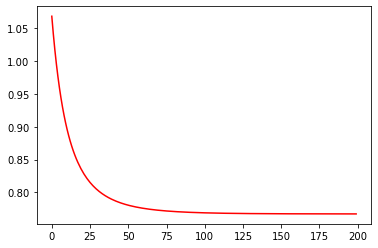

In [27]:
X_spiral,y_spiral = gen_spiral_dataset()
X = X_spiral
y = y_spiral

alpha = 1e-0
iterations  =200
reg = 1e-3

w = np.zeros([X.shape[1]+1,len(np.unique(y))])
w_history = gradient_descent_softmax(w,X,y,reg,alpha,iterations)
w = w_history[-1]
print("w: ",w)
loss_history = compute_loss_history(w_history,X,y,reg)
print(loss_history[:-1:len(loss_history)//10])
plt.plot(loss_history, color='r')

下面函数可以计算训练模型在一批数据(X,y)上的预测准确性：

In [28]:
def getAccuracy(w,X,y):
    X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype),X))  #添加一列特征1 
    probs = softmax(np.dot(X,w))
    predicts = np.argmax(probs,axis=1) 
    accuracy = sum(predicts == y)/(float(len(y)))
    return accuracy

对刚才的数据集用getAccuracy()计算训练得到的softmax模型的预测准确度。

In [29]:
getAccuracy(w,X_spiral,y_spiral)

0.5133333333333333

下面代码绘制出对于这个问题的softmax模型的分类边界：

(-1.9181692991988153, 1.901830700801188)

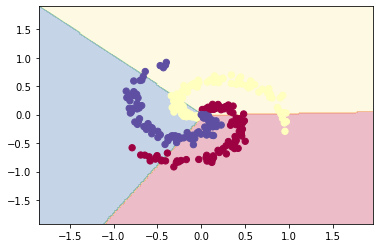

In [30]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = np.dot(np.c_[np.ones(xx.size),xx.ravel(), yy.ravel()], w) 
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')

可见softmax回归本质上仍然是线性函数模型，表现在图形上其分割线都是一些直线，很难对数据进行非线性分割，模型的准确度是 0.5366666666666666 。

## 3.7 批梯度下降法和随机梯度下降法

下面代码读取MNIST手写数字训练集：

In [35]:
import pickle, gzip, urllib.request, json
import numpy as np
import os.path

if not os.path.isfile("./mnist.pkl.gz"):
    # Load the dataset
    urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
    
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

train_X, train_y = train_set
valid_X, valid_y = valid_set
test_X, test_y = valid_set
print(train_X.shape,train_y.shape)
print(valid_X.shape,valid_y.shape)
print(test_X.shape,test_y.shape)
print(train_X.dtype,train_y.dtype)
print(train_X[9][300],train_y[9])
print(np.min(train_y),np.max(train_y))

(50000, 784) (50000,)
(10000, 784) (10000,)
(10000, 784) (10000,)
float32 int64
0.98828125 4
0 9


可视化其中的一幅图像：

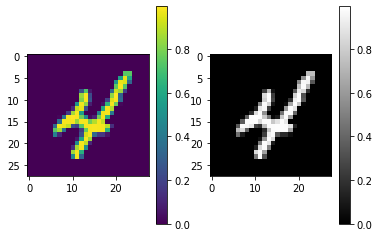

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
digit = train_X[9].reshape(28,28)
plt.subplot(1,2,1)
plt.imshow(digit)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(digit,cmap='gray')
plt.colorbar()
plt.show()

继续输出该样本中的少数像素值（数据特征）。

In [37]:
print(train_X.shape)
print(train_X[9][200:250])

(50000, 784)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.75       0.984375
 0.73046875 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.2421875  0.72265625 0.0703125  0.         0.         0.
 0.         0.34765625 0.921875   0.84765625 0.18359375 0.
 0.         0.        ]


In [38]:
len(np.unique(train_y))

10

### 3.7.2 用部分训练样本训练逻辑回归

训练集的样本数目达到50000个，用整个训练集的样本进行训练，每次计算都需要消耗很多资源和时间，为了提高训练效率，可以从中取出部分数据，如用batch=500个样本进行训练：

In [39]:
batch = 500

alpha  =1e-2
iterations  =1000
reg = 1e-3

w_history=[]

w = np.zeros([train_X.shape[1]+1,len(np.unique(train_y))])
for i in range(5):
    s = i*batch
    X = train_X[s :s+batch,:]
    y = train_y[s :s+batch]
    w_history_batch = gradient_descent_softmax(w,X,y,reg,alpha,iterations)
    w = w_history_batch[-1]
    w_history.extend(w_history_batch)
    
print("w: ",w)
loss_history = compute_loss_history(w_history,X,y,reg)
print(loss_history[:-1:len(loss_history)//10])

w:  [[-0.1081236   0.15722483 -0.03458512 ...  0.14556747 -0.28445635
  -0.0646967 ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[2.291196965908743, 0.8358952420130783, 0.6737094231518491, 0.5552073298551985, 0.5205304526858188, 0.47774180354644386, 0.46429501547666524, 0.45662996516999915, 0.45159800707999126, 0.33682879016290596]


分别计算模型函数在训练集、验证集、测试集上的准确性：

In [40]:
print("训练集的准确性：",getAccuracy(w,train_X,train_y))
print("验证集的准确性：",getAccuracy(w,valid_X,valid_y))
print("测试集的准确性：",getAccuracy(w,test_X,test_y))

训练集的准确性： 0.86746
验证集的准确性： 0.8837
测试集的准确性： 0.8837


绘制训练集和验证集的迭代损失学习曲线：

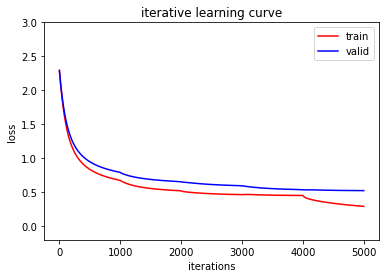

In [41]:
loss_history_valid = compute_loss_history(w_history,valid_X[0:1000,:],valid_y[0:1000],reg)

plt.plot(loss_history, color='r')
plt.plot(loss_history_valid, color='b') 
plt.ylim(0,5)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('iterative learning curve')
plt.legend(['train', 'valid'])
plt.ylim(-0.2,3)
plt.show()      

### 3.7.3 批梯度下降法及实现

批梯度下降法的一般做法是：
+ 1) 对原训练集中的样本次序重新排列，即打乱原训练集中样本的次序。
+ 2) 对重排后的训练集，从头开始，依次取出一小批样本，用这一批样本计算模型函数损失的梯度，并更新模型参数。
+ 3) 多次重复 1),2)。
上述中的1),2)完成了对训练集中几乎所有样本的一趟遍历，在这一趟遍历中用不同的一小批样本对模型参数进行了更新。因此，这个1),2)的过程称为一个epoch。3)表示执行多次的epoch。

打乱一个列表的次序可用numpy.random.shuffle()函数，例如：

In [43]:
m=5
indices = list(range(m))
print(indices)
np.random.shuffle(indices)
print(indices)

[0, 1, 2, 3, 4]
[3, 0, 4, 2, 1]


对应一个数据集(X,y)，可定义一个迭代器函数data_iter()，用于打乱原数据集的次序，并每次从数据集中返回batchsize大小的一小批训练样本：

In [44]:
def data_iter(X,y,batch_size,shuffle=False):
    m = len(X)  
    indices = list(range(m))
    if shuffle:                 # shuffle是True表示打乱次序
        np.random.shuffle(indices)
    for i in range(0, m - batch_size + 1, batch_size):
        batch_indices = np.array(indices[i: min(i + batch_size, m)])      
        yield X.take(batch_indices,axis=0), y.take(batch_indices,axis=0)   

批梯度下降法的代码实现：

In [45]:
def batch_gradient_descent_softmax(w,X, y, epochs,batchsize = 50,shuffle = False,
                                   reg=0., alpha=0.01, gamma = 0.8,epsilon=1e-8): 
    w_history = []
    X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype),X)) 
    for epoch in range(epochs):
        for X_batch,y_batch in data_iter(X,y,batchsize,shuffle):
            gradient = gradient_softmax(w,X_batch,y_batch,reg)
            if np.max(np.abs(gradient))<epsilon:
                print("gradient is small enough!")
                print("iterated num is :",i)
                break          
            w = w - (alpha * gradient)
            w_history.append(w)
    return w_history

对Mnist手写数字识别训练集，执行这个批梯度下降法：

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

batchsize = 50
epochs = 5
shuffle = True
alpha = 0.01
reg = 1e-3
gamma = 0.8

X,y = train_X,train_y
w = np.zeros([X.shape[1]+1,len(np.unique(y))])   
w_history = batch_gradient_descent_softmax(w,train_X,train_y,epochs,batchsize,
                                                shuffle,reg,alpha,gamma)
w = w_history[-1]
print("w: ",w)
X,y = train_X[0:1000,:],train_y[0:1000]
loss_history = compute_loss_history(w_history,X,y,reg)
print(loss_history[:-1:len(loss_history)//10])

w:  [[-0.09890649  0.19035131 -0.03117878 ...  0.14393394 -0.35243414
  -0.05794867]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[2.2942163766131958, 0.825158904547747, 0.6438398675045593, 0.5704120876936323, 0.533880124796363, 0.5069954558043879, 0.4900404386824221, 0.47703077354573376, 0.4656898684938826, 0.46128832814843856]


下面输出模型在不同样本集上的准确度。

In [47]:
print("训练集的准确性：",getAccuracy(w,train_X,train_y))
print("验证集的准确性：",getAccuracy(w,valid_X,valid_y))
print("测试集的准确性：",getAccuracy(w,test_X,test_y))

训练集的准确性： 0.8934
验证集的准确性： 0.9054
测试集的准确性： 0.9054


绘制迭代学习曲线：

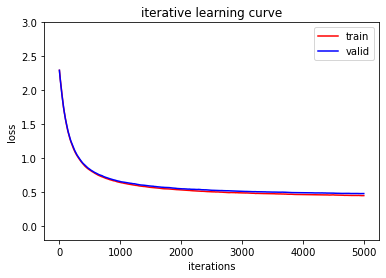

In [48]:
loss_history_valid = compute_loss_history(w_history,valid_X[0:1000,:],valid_y[0:1000],reg)

plt.plot(loss_history, color='r')
plt.plot(loss_history_valid, color='b') 
plt.ylim(0,5)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('iterative learning curve')
plt.legend(['train', 'valid'])
plt.ylim(-0.2,3)
plt.show()    

模型参数矩阵 𝑊 是一个 𝑛×𝐶 矩阵，其每一列对应一个类似逻辑回归的分类器，该列的权值用于从数据中提取能判断数据中和该类相关的特征。对于MNIST图像分类的模型参数 𝑊 ，可将其某一列（对应某个分类）的784大小的权重参数以图像形式显示出来。如下面的代码显示第0列（对应数字0的那个类）的权重参数，将这列向量转化为 28×28 大小的图像矩阵：

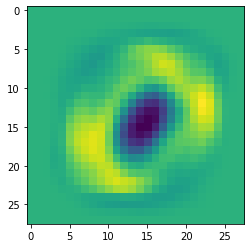

In [49]:
c = 0
plt.imshow(w[1:,c].reshape((28,28)))
plt.show()

Fasion MNIST训练集的softmax回归

In [2]:
import mnist_reader
X_train, y_train = mnist_reader.load_mnist('Fashion-MNIST/raw', kind='train')
X_test, y_test = mnist_reader.load_mnist('Fashion-MNIST/raw', kind='t10k')
print(X_train.shape,y_train.shape)
print(X_train.dtype,y_train.dtype)

FileNotFoundError: [Errno 2] No such file or directory: 'Fashion-MNIST/raw/train-labels-idx1-ubyte.gz'

显示其中的一些图像：

In [ ]:
from matplotlib import pyplot
trainX = X_train.reshape(-1,28,28)
print(trainX.shape)
#lot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [ ]:
train_X = X_train.astype('float32')/255.0
test_X = X_test.astype('float32')/255.0
print(train_X.shape,y_train.shape)
print(test_X.shape,y_test.shape)
print(test_X.dtype,y_test.dtype)
print(np.mean(train_X[0:1000,:]))
print(np.mean(test_X[0:1000,:]))
train_y = y_train

In [ ]:
len(np.unique(train_y))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

batchsize = 50
epochs = 5
shuffle = True
alpha = 0.01
reg = 1e-3
gamma = 0.8

w = np.zeros([train_X.shape[1]+1,len(np.unique(train_y))])   
w_history = batch_gradient_descent_softmax(w,train_X,train_y,epochs,batchsize,
                                                shuffle,reg,alpha,gamma)
w = w_history[-1]
print("w: ",w)
X,y = train_X[0:1000,:],train_y[0:1000]
loss_history = compute_loss_history(w_history,X,y,reg)
print(loss_history[:-1:len(loss_history)//10])

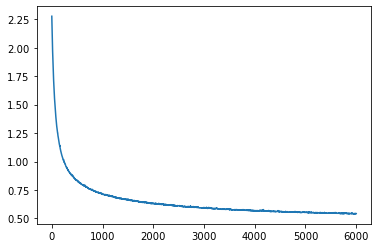

In [60]:
plt.plot(loss_history)

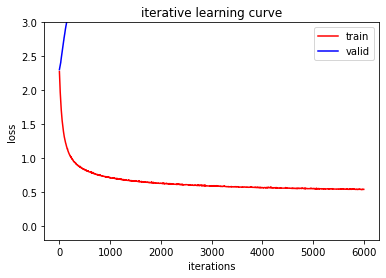

In [61]:
loss_history_valid = compute_loss_history(w_history,test_X[0:1000,:],test_y[0:1000],reg)

plt.plot(loss_history, color='r')
plt.plot(loss_history_valid, color='b') 
plt.ylim(0,5)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('iterative learning curve')
plt.legend(['train', 'valid'])
plt.ylim(-0.2,3)
plt.show()  

In [62]:
print("训练集的准确性：",getAccuracy(w,train_X,train_y))
print("测试集的准确性：",getAccuracy(w,test_X,test_y))

训练集的准确性： 0.82795
测试集的准确性： 0.0997


### 3.7.4 随机梯度下降法

批梯度下降法每次迭代只用一小批样本，而随机梯度下降法更加极端，每次迭代只用一个样本。因此，要执行随机梯度下降，只要将上述代码中调用批梯度下降法前将批大小batchsize修改为1，即每次只用一个样本更新模型参数，为了节省训练时间，将epochs改为2次：

In [63]:
batchsize=1
epochs = 2
w = np.zeros([train_X.shape[1]+1,len(np.unique(train_y))])   
w_history = batch_gradient_descent_softmax(w,train_X,train_y,epochs,batchsize,
                                                shuffle,reg,alpha,gamma)
w = w_history[-1]
print("w: ",w)

w:  [[ 3.43980083e-01 -3.82689114e-01 -7.55376465e-02 ... -4.76886905e-02
  -4.25716194e-01 -1.09449897e+00]
 [-1.86327347e-04 -8.12335257e-06 -1.44934912e-04 ... -1.14782815e-06
  -5.92479477e-05 -5.37628266e-06]
 [ 7.51956062e-04 -7.79895436e-07 -5.96445960e-06 ... -1.39582421e-05
  -6.60711501e-04 -2.38648043e-05]
 ...
 [-4.42026477e-02 -7.47829152e-03  7.41820965e-02 ... -8.84571836e-03
  -7.05771139e-02 -3.17087510e-03]
 [-2.04871398e-02 -9.44509010e-04  2.08531136e-02 ... -2.77501709e-03
  -3.71061063e-02  4.02894187e-03]
 [-8.15255742e-04 -5.30418756e-04  4.76885923e-03 ... -7.14505216e-04
  -4.01528037e-03  1.51593039e-03]]


In [64]:
print("训练集的准确性：",getAccuracy(w,train_X,train_y))
print("测试集的准确性：",getAccuracy(w,test_X,y_test))

训练集的准确性： 0.8041166666666667
测试集的准确性： 0.785
